In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/weather-data/weather_data.csv


In [23]:
!pip install --upgrade scikit-learn


In [24]:
!pip install -U xgboost


In [25]:
train = pd.read_csv("/kaggle/input/weather-data/weather_data.csv")
train.head()

,date,avg_temperature,humidity,avg_wind_speed,rain_or_not,cloud_cover,pressure
0,2023-01-01,23.745401,46.140905,7.845981,Rain,20.851051,992.965681
1,2023-01-02,30.030503,59.876587,5.382457,Rain,93.059521,1037.273025
2,2023-01-03,28.365224,51.464618,13.158008,Rain,11.636640,1034.193357
3,2023-01-04,27.550929,53.103799,5.886677,Rain,81.744971,968.610142
4,2023-01-05,23.639303,57.826186,12.248992,Rain,38.062329,1030.264331


In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             311 non-null    object 
 1   avg_temperature  296 non-null    float64
 2   humidity         296 non-null    float64
 3   avg_wind_speed   296 non-null    float64
 4   rain_or_not      311 non-null    object 
 5   cloud_cover      296 non-null    float64
 6   pressure         311 non-null    float64
dtypes: float64(5), object(2)
memory usage: 17.1+ KB


In [27]:
# 1. Convert date column to datetime and extract features
train['date'] = pd.to_datetime(train['date'])
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['weekday'] =train['date'].dt.weekday  # Monday=0, Sunday=6

In [28]:
print(train['rain_or_not'].unique())


train['rain_or_not'] = train['rain_or_not'].map({'Rain': 1, 'No Rain': 0})

['Rain' 'No Rain']


In [29]:
train= train.drop(columns=['date'])

In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   avg_temperature  296 non-null    float64
 1   humidity         296 non-null    float64
 2   avg_wind_speed   296 non-null    float64
 3   rain_or_not      311 non-null    int64  
 4   cloud_cover      296 non-null    float64
 5   pressure         311 non-null    float64
 6   month            311 non-null    int32  
 7   day              311 non-null    int32  
 8   weekday          311 non-null    int32  
dtypes: float64(5), int32(3), int64(1)
memory usage: 18.4 KB


In [31]:

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
train[['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover']] = imputer.fit_transform(train[['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover']])

In [32]:
train.isnull().sum()

avg_temperature    0
humidity           0
avg_wind_speed     0
rain_or_not        0
cloud_cover        0
pressure           0
month              0
day                0
weekday            0
dtype: int64

<Figure size 1500x1000 with 0 Axes>

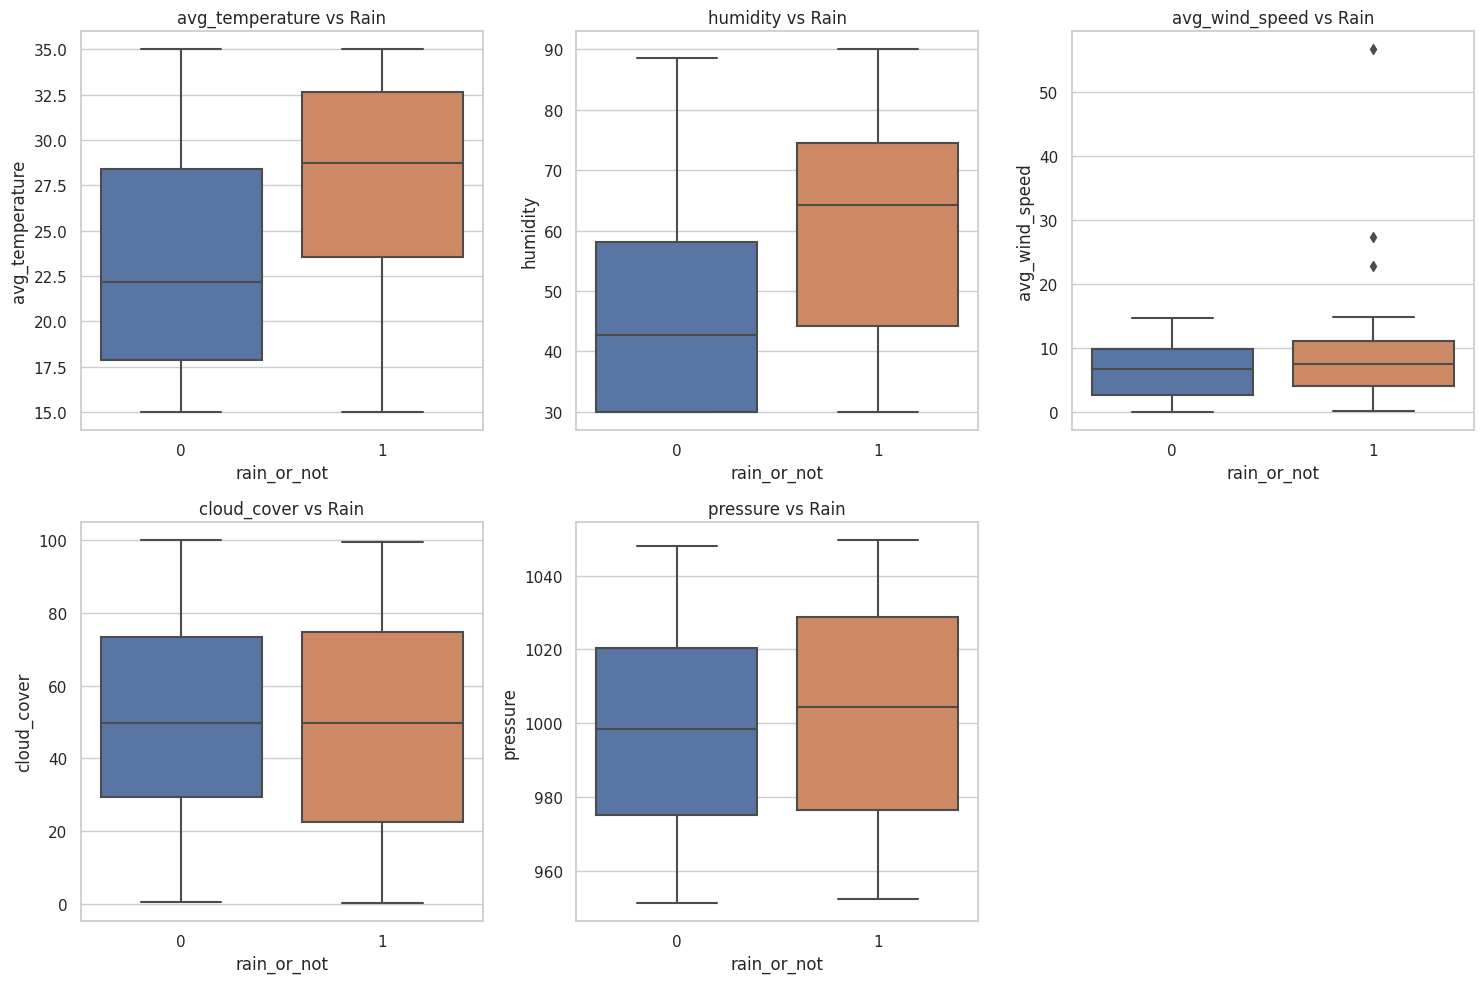

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))

numerical_features = ['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover', 'pressure']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='rain_or_not', y=feature, data=train)
    plt.title(f'{feature} vs Rain')
plt.tight_layout()
plt.show()

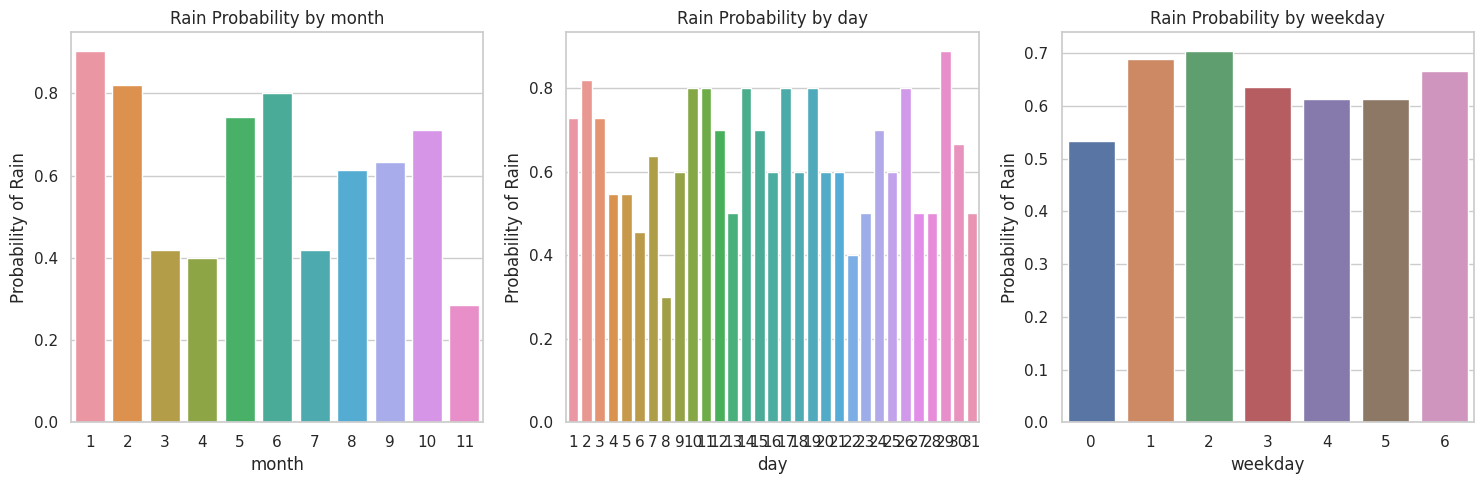

In [34]:
temporal_features = ['month', 'day', 'weekday']

plt.figure(figsize=(15, 5))
for i, feature in enumerate(temporal_features, 1):
    plt.subplot(1, 3, i)
    rain_ratio = train.groupby(feature)['rain_or_not'].mean().reset_index()
    sns.barplot(x=feature, y='rain_or_not', data=rain_ratio)
    plt.title(f'Rain Probability by {feature}')
    plt.ylabel('Probability of Rain')
plt.tight_layout()
plt.show()

In [35]:
train.describe()

,avg_temperature,humidity,avg_wind_speed,rain_or_not,cloud_cover,pressure,month,day,weekday
count,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000
mean,25.983840,55.041385,7.556636,0.636656,49.834827,1001.059119,5.649518,15.450161,2.993569
std,6.635859,18.749365,5.213773,0.481738,28.298916,28.835595,2.957111,8.885831,2.011248
min,15.000000,30.000000,0.069480,0.000000,0.321826,951.240404,1.000000,1.000000,0.000000
25%,20.493383,35.686194,3.711684,0.000000,25.955498,975.757545,3.000000,8.000000,1.000000
50%,25.983840,55.041385,7.556636,1.000000,49.834827,1001.938586,6.000000,15.000000,3.000000
75%,31.858688,71.978037,10.897166,1.000000,74.162107,1026.578884,8.000000,23.000000,5.000000
max,35.000000,90.000000,56.636041,1.000000,99.834751,1049.543752,11.000000,31.000000,6.000000


In [36]:
# Create categorical versions
train['wind_speed_bin'] = pd.cut(train['avg_wind_speed'],
                             bins=[0, 5, 10, 15, 20, np.inf],
                             labels=[0, 1, 2, 3, 4])

train['cloud_cover_bin'] = pd.cut(train['cloud_cover'],
                              bins=[0, 25, 50, 75, 100],
                              labels=[0, 1, 2, 3])

In [37]:
train=train.drop(columns=['avg_wind_speed'])

In [38]:
train=train.drop(columns=['cloud_cover'])

In [39]:
from sklearn.feature_selection import mutual_info_classif

# Separate features and target
X = train.drop(['rain_or_not'], axis=1)  
y = train['rain_or_not']

# Calculate MI scores
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_scores = pd.Series(mi_scores, index=X.columns, name="MI Scores").sort_values(ascending=False)

print(mi_scores)

humidity           0.070412
month              0.068081
avg_temperature    0.054652
pressure           0.020196
wind_speed_bin     0.017794
day                0.000000
weekday            0.000000
cloud_cover_bin    0.000000
Name: MI Scores, dtype: float64


In [40]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   avg_temperature  311 non-null    float64 
 1   humidity         311 non-null    float64 
 2   rain_or_not      311 non-null    int64   
 3   pressure         311 non-null    float64 
 4   month            311 non-null    int32   
 5   day              311 non-null    int32   
 6   weekday          311 non-null    int32   
 7   wind_speed_bin   311 non-null    category
 8   cloud_cover_bin  311 non-null    category
dtypes: category(2), float64(3), int32(3), int64(1)
memory usage: 14.5 KB


In [45]:
import sklearn
import xgboost as xgb

print(f"scikit-learn version: {sklearn.__version__}")
print(f"xgboost version: {xgb.__version__}")

scikit-learn version: 1.6.1
xgboost version: 2.0.3


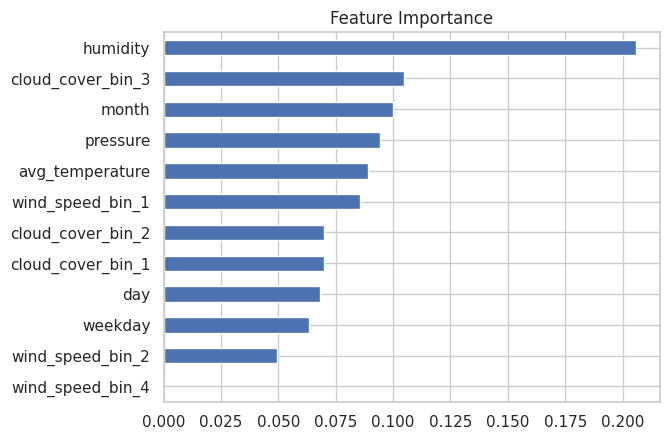

In [41]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Prepare data (same as before)
X=train.drop(columns=['rain_or_not'], axis=1)
y = train['rain_or_not']

# Define numeric and categorical features
numeric_features = ['avg_temperature','humidity','pressure','month','day','weekday']
categorical_features = ['wind_speed_bin', 'cloud_cover_bin']

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

# Create pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        scale_pos_weight=sum(y==0)/sum(y==1),
        eval_metric='logloss',
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    ))
])

# Train-test split (on raw data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit pipeline
pipeline.fit(X_train, y_train)

# Feature importance with names
xgb = pipeline.named_steps['classifier']
feature_names = numeric_features+ \
               pipeline.named_steps['preprocessor'].named_transformers_['cat'] \
               .get_feature_names_out(categorical_features).tolist()

pd.Series(xgb.feature_importances_, index=feature_names) \
  .sort_values() \
  .plot(kind='barh', title='Feature Importance')
plt.show()

In [43]:
from sklearn.metrics import classification_report


# Predict on the test set
y_pred = pipeline.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred, target_names=['No Rain', 'Rain']))


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [ ]:
# Access numeric and categorical transformers
preprocessor = pipeline.named_steps['preprocessor']

# Numeric features (pass-through)
numeric_features = preprocessor.transformers_[0][2]  # same as before

# One-hot encoded categorical feature names
ohe = preprocessor.named_transformers_['cat']
categorical_feature_names = ohe.get_feature_names_out(['wind_speed_bin', 'cloud_cover_bin'])


# Combine numeric + encoded categorical
full_feature_names = list(numeric_features) + list(categorical_feature_names)
print(full_feature_names)

In [ ]:
import joblib
joblib.dump(pipeline, 'rain_predictor_pipeline.pkl')